# 뉴스기사 요약봇 만들기
- 목표
    - 뉴스기사를 자동으로 추상적 요약과 추출적 요약을 하는 프로그램 작성하기
- 방법
    - 데이터 가져오기
    - 추상적 요약하기
        - 데이터 전처리하기
        - 시퀀스의 최대 길이를 정하고 기준보다 긴 문장 제외하기
        - decoder 학습용 데이터에 시작 토큰과 종료 토큰 달기
        - 학습 데이터셋과 테스트 데이터셋으로 나누기
        - 기사문과 헤드라인에서 단어 사전을 만들기
        - 낮은 빈도수의 단어 조사하고 처리하기
        - 각 단어를 정수로 인코딩하기
        - 시퀀스의 길이를 맞춰주기
        - 어텐션과 LSTM을 사용하는 Seq2Seq 학습용 모델 설계하기
        - Seq2Seq 모델이 요약문을 생성하도록 학습시키기
        - 학습된 레이어를 재구성하여 요약문 생성용 모델로 만들기
        - 실제 헤드라인과 모델이 생성한 요약문을 비교해보기
    - 추출적 요약하기

# 1. 데이터 가져오기


In [1]:
import pandas as pd
import urllib.request

# 신문 기사 데이터 다운로드 후 pandas로 불러오기
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [2]:
# 가져온 신문 기사 데이터의 열 정보 보기
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [3]:
# 신문 기사 데이터 살펴보기
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## 데이터 구조
- headelines
    - 뉴스의 핵심 내용이 담긴 제목
    - 모델이 생성해야하는 타겟 데이터로 활용한다
- text
    - 뉴스 기사 텍스트
    - 모델이 요약해야하는 샘플 데이터로 활용한다

In [4]:
# 결측치 확인하기
data.isnull().sum()

headlines    0
text         0
dtype: int64

# 2. 추상적 요약하기
## 2.1. 데이터 전처리하기
- 중복 데이터 제거
- 모든 글자 소문자화
- 단어 정규화하기
    - 같은 의미지만 다른 표기를 지닌 단어들을 통일하기
    - 모델이 인식해야하는 단어 수를 줄여준다
- 불용문 제거하기
    - 요약하는데 도웅을 거의 주지 않는 단어 제거하기
- html 태그 제거하기
- 괄호로 둘어싸인 구문 제거하기
- 쌍따옴표 제거
- 소유격 제거
- 알파벳 이외의 글자 제거
- 의성어 길이 제안하기 (ex: uhmmmmmmmmmmmm)

In [ ]:
# 중복 데이터 확인
print('text에서 중복 데이터를 제외한 개수:', data['text'].nunique())
print('headlines에서 중복 데이터를 제외한 개수:', data['headlines'].nunique())

In [5]:
# 정규화 사전 가져오기
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [6]:
# NLTK가 제공하는 불용문(stopwords) 목록 가져오기
import nltk
nltk.download('stopwords') # 반드시 stopwords를 import하기 전에 실행해야함

from nltk.corpus import stopwords

stopwords_list = stopwords.words('english')
stopwords_list[:10]

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [7]:
from bs4 import BeautifulSoup 
import re


# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 단어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [8]:
# text와 headlines 전처리하기
data['text'] = data['text'].apply(preprocess_sentence)
data['headlines'] = data['headlines'].apply(lambda x: preprocess_sentence(x, False))

# 전처리 결과 확인해보기
data.head()

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...


## 2.2. 시퀀스 최대 길이 정하기
- 시퀀스 길이의 통계치 확인하기
- 시퀀스 최대 길이를 정하고 얼마나 많은 시퀀스가 포함되는지 확인
- 최대 길이를 넘는 시퀀스들 제외하기

In [9]:
# 길이 분포 출력
import numpy as np
import matplotlib.pyplot as plt

# 각 문장의 단어 개수(문장의 길이) 구하기
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

# text와 headlines의 통계치(최솟값, 최댓값, 평균, 표준편차) 구하기
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('텍스트의 길이 표준편차 : {}'.format(np.std(text_len)))
print('-'*80)
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('헤드라인의 길이 표준편차 : {}'.format(np.std(headlines_len)))

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09983638377659
텍스트의 길이 표준편차 : 3.799503566121209
--------------------------------------------------------------------------------
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299651426306644
헤드라인의 길이 표준편차 : 1.3900508332906916


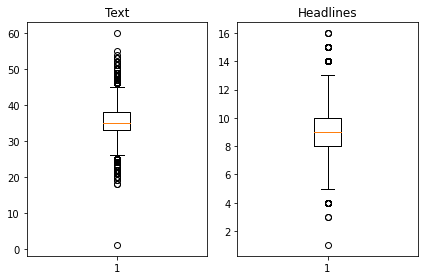

In [10]:
# text와 headlines의 길이 상자 그래프 그리기
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

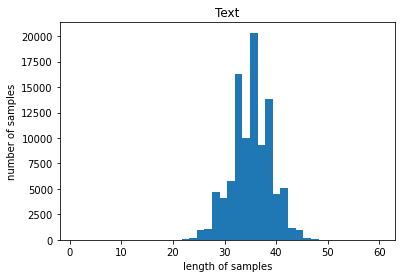

In [11]:
# text의 히스토그램 그리기
plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

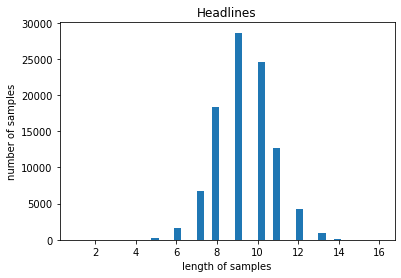

In [12]:
# headlines의 히스토그램 그리기
plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [13]:
# 평균과 표준편차로 text의 최대길이 정해보기
text_len_mean = np.mean(text_len)
text_len_std = np.std(text_len)
text_max_len = np.floor(text_len_mean + 2 * text_len_std)

print("text의 최대 길이:", text_max_len)
print("최대 길이를 넘지 않는 text:", (text_len <= text_max_len).sum() / len(text_len) * 100, "%")

text의 최대 길이: 42.0
최대 길이를 넘지 않는 text: 97.50307415575044 %


In [14]:
# 평균과 표준편차로 headlines의 최대길이 정해보기 
headlines_len_mean = np.mean(headlines_len)
headlines_len_std = np.std(headlines_len)
headlines_max_len = np.floor(headlines_len_mean + 2 * text_len_std)

print("headlines의 최대 길이:", headlines_max_len)
print("최대 길이를 넘지 않는 headlines:", (headlines_len <= headlines_max_len).sum() / len(headlines_len) * 100, "%")

headlines의 최대 길이: 16.0
최대 길이를 넘지 않는 headlines: 100.0 %


In [15]:
# 최대 길이를 넘는 데이터 제거하기
text_is_under_max_len = (0 < data['text'].apply(lambda x: len(x.split()))) \
                        & (data['text'].apply(lambda x: len(x.split())) <= text_max_len)
headlines_is_under_max_len = (0 < data['headlines'].apply(lambda x: len(x.split()))) \
                             & (data['headlines'].apply(lambda x: len(x.split())) <= headlines_max_len)

data = data[text_is_under_max_len & headlines_is_under_max_len]
print("data의 남은 개수:", len(data))

data의 남은 개수: 95944


## 2.3. decoder 데이터에 시작 토큰과 종료 토큰 넣기
- 시작 토큰
    - decoder가 시퀀스를 생성하도록 알려주는 토큰
    - encoder의 hidden state와 함께 첫 step의 입력값으로 들어간다
- 종료 토큰
    - decoder가 시퀀스 생성이 끝났음을 알려주는 토큰
    - 학습할 때 모델이 생성한 시퀀스의 끝을 반드시 종료 토큰을 내밷도록 한다

In [16]:
# decoder 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


## 2.4. 학습 데이터셋과 테스트 데이터셋으로 분리하기
- 인코더의 입력 테이터와 디코더의 입력/타겟 데이터 만들기
- 학습 데이터셋과 테스트 데이터셋으로 나누기

In [17]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [18]:
# 데이터셋의 인덱스를 섞기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

# 섞은 인덱스를 따라 데이터셋 섞기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [19]:
# 테스트 데이터셋 크기 정하기
n_of_val = int(len(encoder_input)*0.2)

# 학습 데이터셋
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

# 테스트 데이터셋
encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

# 나눠진 데이터셋 크기 확인하기
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 76756
훈련 레이블의 개수 : 76756
테스트 데이터의 개수 : 19188
테스트 레이블의 개수 : 19188


## 2.5. 단어 사전 만들고 정수 인코딩 하기
- 데이터셋에서 단어 추출하고 단어 사전 만들기
- 빈도를 분석하고 낮은 빈도의 단어 제외하기
    - 낮은 빈도의 단어는 많지만 총 빈도는 작다
    - 낮은 빈도를 제외하면 모델이 인식해야하는 단어 수를 줄이면서 데이터 품질은 최대한 유자한다
- 만들어진 단어 사전으로 텍스트를 정수 시퀀스로 변환
- 낮은 빈도 단어 제거로 문장이 없어진 데이터 제외하기

In [20]:
# 인코더의 샘플 데이터에서 모든 단어 찾기
from tensorflow.keras.preprocessing.text import Tokenizer

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [21]:
threshold = 7 # 낮은 빈도 기준
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68184
등장 빈도가 6번 이하인 희귀 단어의 수: 46382
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21802
단어 집합에서 희귀 단어의 비율: 68.02475654112402
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.530060198869263


In [22]:
# 낮은 빈도 단어를 제외하기 위한 빈도 순위 커트라인
src_vocab = 20000

# 낮은 빈도의 단어를 제외한 인코더의 단어 사전 만들기
src_tokenizer = Tokenizer(num_words=src_vocab) # 남길 단어 수
src_tokenizer.fit_on_texts(encoder_input_train)

In [23]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[5, 39, 546, 81, 1143, 17, 1746, 13097, 1461, 1001, 517, 437, 78, 3359, 8819, 99, 1882, 17, 1746, 515, 17, 14013, 15080, 12, 3643, 4147, 287, 84, 146, 1852, 636, 1525, 10251, 546, 1], [4530, 3413, 5032, 8686, 42, 8526, 2741, 2567, 798, 31, 1396, 2729, 5, 252, 239, 3374, 7, 26, 101, 239, 532, 1046, 4, 13, 1, 2913, 2713, 3249, 1007, 5804, 3], [2, 372, 260, 7, 127, 1802, 142, 593, 85, 315, 220, 735, 90, 2, 637, 315, 735, 90, 403, 435, 756, 3995, 2, 403, 260, 1802, 303, 90, 1555, 41, 1876]]


In [24]:
# 디코더의 샘플 데이터에서 모든 단어 찾기
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [25]:
threshold = 6 # 낮은 빈도 기준
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29650
등장 빈도가 5번 이하인 희귀 단어의 수: 19324
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10326
단어 집합에서 희귀 단어의 비율: 65.17369308600337
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.670600487699322


In [26]:
# 낮은 빈도 단어를 제외하기 위한 빈도 순위 커트라인
tar_vocab = 10000

# 낮은 빈도의 단어를 제외한 디코더의 단어 사전 만들기
tar_tokenizer = Tokenizer(num_words=tar_vocab) # 남길 단어 수
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [27]:
# 헤드라인 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 358, 2979, 5789, 6, 189, 1879, 7, 117, 2794], [1, 62, 10, 5790, 159, 66, 3611, 2259, 7, 1335, 2687], [1, 9, 111, 230, 384, 210, 717, 4, 4], [1, 9359, 5542, 2629, 6, 327, 4049, 4, 144], [1, 421, 360, 2919, 1935, 6385, 7, 9360, 2031, 4, 634]]
target
decoder  [[358, 2979, 5789, 6, 189, 1879, 7, 117, 2794, 2], [62, 10, 5790, 159, 66, 3611, 2259, 7, 1335, 2687, 2], [9, 111, 230, 384, 210, 717, 4, 4, 2], [9359, 5542, 2629, 6, 327, 4049, 4, 144, 2], [421, 360, 2919, 1935, 6385, 7, 9360, 2031, 4, 634, 2]]


In [28]:
# decoder_input_train 중 낮은 빈도 단어 제거로 없어진 문장 찾기
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

# 학습 데이터셋에서 생긴 결측치 제거
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

# 테스트 데이터셋에서 생긴 결측치 제거
encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 76755
훈련 레이블의 개수 : 76755
테스트 데이터의 개수 : 19188
테스트 레이블의 개수 : 19188


## 2.6. 모든  시퀀스 길이 맞추기
- 패딩을 통해 모든 시퀀스 길이를 최대 길이로 맞춰주기

In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


text_max_len = int(text_max_len)
headlines_max_len = int(headlines_max_len)

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 2.7. 학습용 모델 설계하기
- LSTM과 어텐셜 메커니즘을 이용하는 Seq2Seq 모델 설계하기
- 입력: encoder_input_train, decoder_input_train
- 출력: decoder_target_train

In [79]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,), name='encoder_input')

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim, name='encoder_embedding')(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, name='encoder_lstm1')
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4, name='encoder_lstm2')
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, dropout = 0.4, name='encoder_lstm3')
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [80]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [81]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 42, 128)      2560000     input_21[0][0]                   
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 42, 256), (N 394240      embedding_4[0][0]                
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

## 2.8. 모델 학습하기
- early stopping을 적용하고 학습하기
- 학습하면서 학습 loss와 검증 loss의 변화 확인하기
    - 모델이 잘 학습했는지 그래프로 확인하기

In [54]:
# 모델 학습하기
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) # early stopping callback 객체
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
300/300 [==============================] - 101s 315ms/step - loss: 4.3268 - val_loss: 4.0521
Epoch 2/50
300/300 [==============================] - 91s 302ms/step - loss: 3.9857 - val_loss: 3.8638
Epoch 3/50
300/300 [==============================] - 94s 312ms/step - loss: 3.7636 - val_loss: 3.6292
Epoch 4/50
300/300 [==============================] - 91s 303ms/step - loss: 3.5485 - val_loss: 3.4693
Epoch 5/50
300/300 [==============================] - 91s 302ms/step - loss: 3.3951 - val_loss: 3.3625
Epoch 6/50
300/300 [==============================] - 93s 311ms/step - loss: 3.2715 - val_loss: 3.2715
Epoch 7/50
300/300 [==============================] - 91s 302ms/step - loss: 3.1660 - val_loss: 3.1985
Epoch 8/50
300/300 [==============================] - 90s 300ms/step - loss: 3.0743 - val_loss: 3.1340
Epoch 9/50
300/300 [==============================] - 93s 310ms/step - loss: 2.9922 - val_loss: 3.0943
Epoch 10/50
300/300 [==============================] - 91s 302ms/step - 

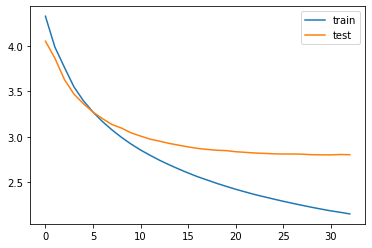

In [55]:
# 학습 경과 그래프 그리기
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 2.9. 요약문 생성용 모델로 재구성하기
- 학습한 모델에서 레이어를 다시 생성용 모델로 재구성하기
- 입력: encoder_input_train
- 출력: decoder_target_train, hidden_s, hidden_c

In [76]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,), name='decoder_input_h')
decoder_state_input_c = Input(shape=(hidden_size,), name='decoder_input_c')

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

encoder_model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 42)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 42, 128)           2560000   
_________________________________________________________________
lstm_4 (LSTM)                [(None, 42, 256), (None,  394240    
_________________________________________________________________
lstm_5 (LSTM)                [(None, 42, 256), (None,  525312    
_________________________________________________________________
lstm_6 (LSTM)                [(None, 256), (None, 256) 525312    
Total params: 4,004,864
Trainable params: 4,004,864
Non-trainable params: 0
_________________________________________________________________


In [77]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

decoder_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 128)    1280000     input_10[0][0]                   
__________________________________________________________________________________________________
decoder_input_h (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
decoder_input_c (InputLayer)    [(None, 256)]        0                                            
___________________________________________________________________________________________

In [70]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 2.10. 모델의 학습 결과 확인하기
- 모델에게 기사 원문을 주고 요약문 생성하기
- 기사의 헤드라인과 요약문 비교해보기

In [71]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [72]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0):
            temp += src_index_to_word[i] + ' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0):
            temp += tar_index_to_word[i] + ' '
    return temp

In [78]:
# 원문 기사의 실제 헤드라인과 모델의 요약문 비교해보기
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("-" * 80)

원문 : delhi metro rail moved supreme court delhi high court order directing pay crore three months interest lender reliance infrastructure subsidiary delhi airport metro express corporation challenged earlier order favour reliance case relates reliance terminating metro project dmrc failed fix defects 
실제 요약 : sostoken delhi metro moves sc against crore payment to arm 


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 1 is incompatible with layer model_13: expected shape=(None, 42, 256), found shape=(None, 256)


# 3. 추출적 요약해보기
- summa 라이브러리를 이용해 기사를 추출적 요약해보기

In [48]:
import requests
from summa.summarizer import summarize

data_ = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

# 추출적 요약으로 기사 요약하기
for i in range(50, 100):
    print('원문:', data_.iloc[i,1])
    print('요약문:', summarize(data_.iloc[i,1], words=20))
    print('-' * 80)

원문: Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
요약문: Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).
All agencies including regulators of the government have failed to track nefarious deals, he said.
This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
--------------------------------------------------------------------------------
원문: US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's 